In [33]:
from ib_insync import *
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels import regression,stats
import math
import datetime
import statsmodels.formula.api as smf
from datetime import date, time, datetime, timedelta
from xml.etree import ElementTree as ET
from IPython.core.debugger import set_trace
import seaborn as sns
import os
import random

In [4]:
os.getcwd()

'/Users/alessahuang/Desktop/Math590'

## Grab data

In [5]:
# connect to TWS
util.startLoop()
ib = IB()
ib.connect('127.0.0.1', 7497, clientId = 304) 

<IB connected to 127.0.0.1:7497 clientId=304>

In [6]:
# find stock contratcs and qualify them with all attributes
tickers = ['MSFT', 'CAT'] # Microsoft and Caterpillar
contracts = []
for i in range(len(tickers)):
    c = Contract(symbol = tickers[i], secType = 'STK', exchange = 'SMART', currency = 'USD')
    ib.qualifyContracts(c)
    contracts.append(c)


In [7]:
end_day = datetime.strptime('02-01-2021', '%m-%d-%Y').date()

In [8]:
# grab price and volume of the stocks
bars = []
for i in range(len(contracts)):
    bar = ib.reqHistoricalData(
        contracts[i],
        endDateTime = end_day,
        durationStr = '2 Y',
        barSizeSetting = '1 day',
        whatToShow = 'TRADES',
        useRTH = True,
        formatDate = 1
    )
    bars.append(bar)

In [9]:
# convert to dataframe
price1 = util.df(bars[0])
price2 = util.df(bars[1])

In [10]:
price1.head()

,date,open,high,low,close,volume,average,barCount
0,2019-02-04,103.16,105.80,102.77,105.74,225344,105.0085,123417
1,2019-02-05,106.10,107.27,105.96,107.22,196924,106.8185,103942
2,2019-02-06,106.95,107.00,105.53,106.03,148746,106.1105,86308
3,2019-02-07,105.19,105.59,104.29,105.27,198202,104.9995,122584
4,2019-02-08,104.34,105.78,104.26,105.67,155833,104.9910,83529


In [11]:
price2.head()

,date,open,high,low,close,volume,average,barCount
0,2019-02-04,130.80,131.31,130.10,130.88,29241,130.7255,18654
1,2019-02-05,130.63,132.10,130.60,132.00,24213,131.3510,15057
2,2019-02-06,131.27,132.10,130.36,130.54,21093,130.9655,13833
3,2019-02-07,129.29,130.44,127.36,128.78,27372,128.6465,19147
4,2019-02-08,127.48,128.60,126.55,128.60,21661,127.6805,15615


In [13]:
# combine prices of theses two assets
prices = pd.merge(
    left = price1[['date', 'close']],
    right = price2[['close']],
    left_index = True,
    right_index = True,
    suffixes = ('_MSFT','_CAT')
)
d = prices['date'].astype(str)
prices['dates'] = pd.to_datetime(d, format = '%Y-%m-%d')
prices = prices.drop(columns = ['date'])
prices.set_index('dates')


,close_MSFT,close_CAT
dates,,
2019-02-04,105.74,130.88
2019-02-05,107.22,132.00
2019-02-06,106.03,130.54
2019-02-07,105.27,128.78
2019-02-08,105.67,128.60
...,...,...
2021-01-26,232.33,187.21
2021-01-27,232.90,180.63
2021-01-28,238.93,184.34


## Log Return

In [14]:
# compute log teturn
prices['logr_MSFT'] = prices['close_MSFT'].apply(lambda x: np.log(x)).diff()
prices['logr_CAT'] = prices['close_CAT'].apply(lambda x: np.log(x)).diff()
returns = prices[['dates','logr_MSFT', 'logr_CAT']].set_index('dates')
returns = returns.dropna()

## Histogram and Statistics

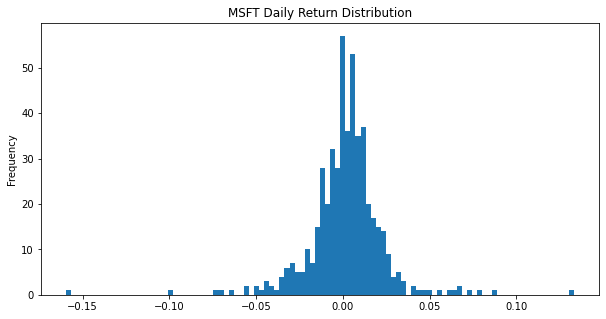

In [15]:
returns['logr_MSFT'].plot.hist(figsize = (10,5), bins = 100, title = tickers[0] + ' Daily Return Distribution')

In [16]:
print('Volatility: ', returns['logr_MSFT'].std(), 'Skew: ', returns['logr_MSFT'].skew(), 
      'Kurtosis: ', returns['logr_MSFT'].kurtosis())

Volatility:  0.021479154414158996 Skew:  -0.5139642635825443 Kurtosis:  10.953788446011258


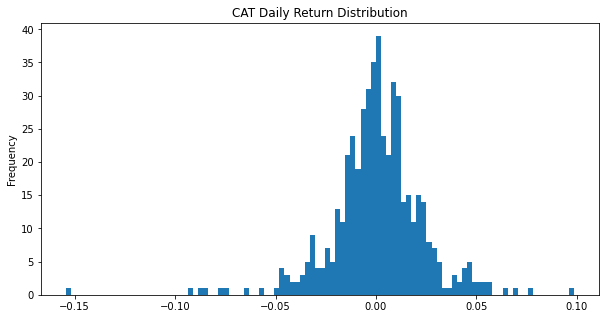

In [17]:
returns['logr_CAT'].plot.hist(figsize = (10,5), bins = 100, title = tickers[1] + ' Daily Return Distribution')

In [18]:
print('Volatility: ', returns['logr_CAT'].std(), 'Skew: ', returns['logr_CAT'].skew(), 
      'Kurtosis: ', returns['logr_CAT'].kurtosis())

Volatility:  0.02295798479796549 Skew:  -0.7161063113823353 Kurtosis:  6.039426769813581


### correlation

In [209]:
print('The correlation between MSFT and CAT: ', returns['logr_MSFT'].corr(returns['logr_CAT']))

The correlation between MSFT and CAT:  0.4924034044622624


## Return: autocorrelation and jumps?

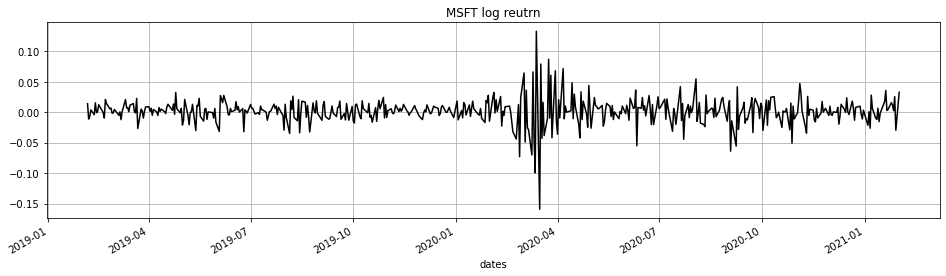

In [19]:
# plot reutrn for MSFT and CAT
ax = returns['logr_MSFT'].plot(kind= 'line', figsize=(16,4), title=tickers[0]+" log reutrn", 
                          legend = False, grid = True, color='black')

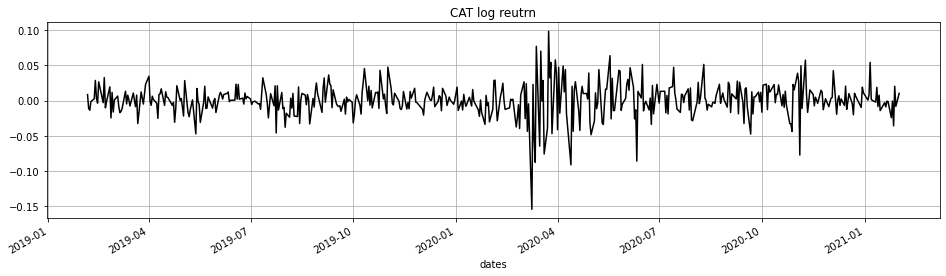

In [20]:
ax = returns['logr_CAT'].plot(kind= 'line', figsize=(16,4), title=tickers[1]+" log reutrn", 
                          legend = False, grid = True, color='black')

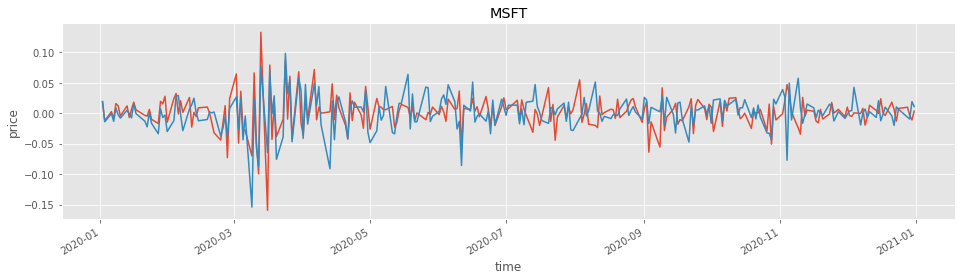

In [21]:
# zoom in
with plt.style.context('ggplot'):
    ax = returns.loc['2020'].plot(kind= 'line', figsize=(16,4), 
                                   title=tickers[0], legend = False, grid = True)
    ax.set(xlabel='time',ylabel = 'price')

## Normality test

In [34]:
from scipy import stats
returns.head()

,logr_MSFT,logr_CAT
dates,,
2019-02-05,0.013900,0.008521
2019-02-06,-0.011161,-0.011122
2019-02-07,-0.007194,-0.013574
2019-02-08,0.003793,-0.001399
2019-02-11,-0.003983,0.002563


### MSFT

In [35]:
x = returns['logr_MSFT']
k2, p = stats.normaltest(x, nan_policy ='omit')
alpha = 0.001
print (k2, p) 
p = 3.27207e-11
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
#The null hypothesis can be rejected

124.66806101896854 8.485442891757445e-28
The null hypothesis can be rejected


### CAT

In [36]:
x = returns['logr_CAT']
k2, p = stats.normaltest(x, nan_policy ='omit')
alpha = 0.001
print (k2, p) 
p = 3.27207e-11
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
#The null hypothesis can be rejected

107.84383711369571 3.8195158548154496e-24
The null hypothesis can be rejected


## Candlestick

### MSFT

In [38]:
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates

/opt/anaconda3/lib/python3.7/site-packages/mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


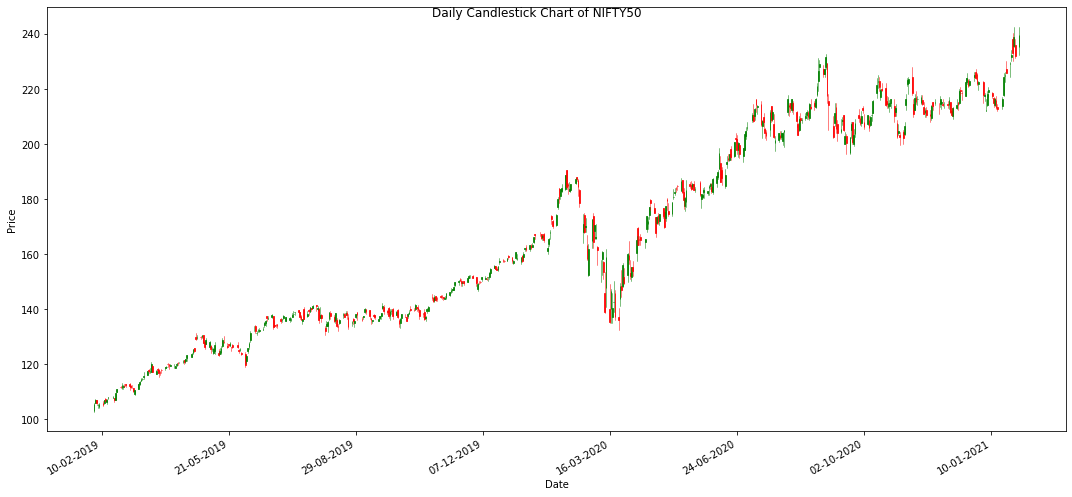

In [39]:
ohlc = price1[['date', 'open', 'high', 'low', 'close']]
ohlc['date'] = pd.to_datetime(ohlc['date'])
ohlc['date'] = ohlc['date'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

# Creating Subplots
fig, ax = plt.subplots(figsize =[15,7])

candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('Daily Candlestick Chart of NIFTY50')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()

plt.show()

In [83]:
w1 = random.random()
w2 = random.random()
while w1 + w2 >1:
    w1 = random.random()
    w2 = random.random()
    
w3 = 1 - w1 -w2

In [84]:
print(w1, w2, w3)
print(w1+w2+w3==1)

0.7055149288037476 0.1724940520826983 0.12199101911355414
True
